In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("embedded_data.csv")

In [3]:
df

File Name                                     Audio Features  \
0      dia81_utt13.mp4  [-396.83575439453125, 174.8942108154297, -49.7...   
1      dia351_utt0.mp4  [-312.864990234375, 152.09201049804688, -38.36...   
2     dia1035_utt0.mp4  [-317.5924072265625, 138.95782470703125, -66.4...   
3      dia660_utt4.mp4  [-421.73248291015625, 156.04544067382812, -28....   
4       dia68_utt0.mp4  [-415.46075439453125, 174.6930389404297, -52.2...   
...                ...                                                ...   
1871   dia679_utt4.mp4  [-355.0843811035156, 157.95748901367188, -46.4...   
1872    dia46_utt1.mp4  [-363.7742919921875, 108.24598693847656, -62.4...   
1873   dia856_utt3.mp4  [-385.1871337890625, 141.83848571777344, -55.2...   
1874   dia344_utt4.mp4  [-332.9544677734375, 196.1272735595703, -52.96...   
1875   dia503_utt0.mp4  [-310.301513671875, 149.76303100585938, -44.94...   

      Dialogue_ID  Utterance_ID    Speaker Sentiment  Season  Episode  \
0              81            13     Phoebe  negative       1        7   
1             351             0  Dr. Green  negative       8        8   
2            1035             0       Joey  negative       4       22   
3             660             4       Paul  negative       6       23   
4              68             0   Director  negative       1        6   
...           ...           ...        ...       ...     ...      ...   
1871          679             4     Rachel  negative       6       21   
1872           46             1       Joey  negative       4       19   
1873          856             3     Rachel  negative       5       13   
1874          344             4       Joey  positive       5       17   
1875          503             0     Monica  negative       5       24   

         StartTime       EndTime  \
0      0:12:04,697   0:12:05,287   
1     00:11:31,982  00:11:38,863   
2     00:02:38,074  00:02:39,867   
3     00:05:05,471  00:05:12,311   
4     00:13:34,730  00:13:39,317   
...            ...           ...   
1871  00:00:12,220  00:00:20,853   
1872  00:12:43,095  00:12:46,264   
1873  00:20:59,508  00:21:02,718   
1874  00:02:25,937  00:02:28,772   
1875  00:11:51,168  00:11:52,460   

                                    Processed_Utterance  Duration  \
0                                                    []     0.590   
1     ['come', 'explain', 'geller', 'first', 'get', ...     6.881   
2                                     ['said', 'could']     1.793   
3     ['instead', 'parent', 'got', 'little', 'plasti...     6.840   
4     ['dammit', 'hire', 'girl', 'okay', 'everybody'...     4.587   
...                                                 ...       ...   
1871                ['op', 'twelfth', 'brings', 'spat']     8.633   
1872    ['ace', 'high', 'jack', 'queen', 'king', 'ace']     3.169   
1873                                  ['joey', 'ready']     3.210   
1874                                  ['whoa', 'maybe']     2.835   
1875                                            ['say']     1.292   

                                Processed_Utterance_Str   Emotion  \
0                                                           anger   
1         come explain geller first get rachel pregnant     anger   
2                                            said could     anger   
3     instead parent got little plastic chicken hop ...     anger   
4                 dammit hire girl okay everybody ready     anger   
...                                                 ...       ...   
1871                             op twelfth brings spat  surprise   
1872                       ace high jack queen king ace  surprise   
1873                                         joey ready  surprise   
1874                                         whoa maybe  surprise   
1875                                                say  surprise   

                                         Video_Features  \
0     tensor([[-2.1098,  0.8341,  0.2451,  ..., -2.8...   
1 

In [4]:
import pandas as pd
import torch
import ast
import re

# Function to handle tensor conversion with error handling
def string_to_tensor(tensor_string):
    # Remove 'tensor(' from the start and ')' from the end
    tensor_string = tensor_string.strip('tensor()')
    
    # Remove newlines and unnecessary spaces
    tensor_string = tensor_string.replace('\n', '').replace(' ', '')
    
    # Remove ellipses and extra commas
    tensor_string = tensor_string.replace('...', '')
    
    # Replace multiple commas with a single comma
    tensor_string = re.sub(r',+', ',', tensor_string)
    
    # Fix trailing and leading commas and empty brackets
    tensor_string = re.sub(r',(\s*\])', r'\1', tensor_string)
    tensor_string = re.sub(r'\[\s*,', '[', tensor_string)
    tensor_string = re.sub(r',\s*\]', ']', tensor_string)
    
    # Wrap the string in square brackets to ensure proper list format
    tensor_string = f'[{tensor_string}]'
    
    # Convert the string to a list using eval
    try:
        tensor_list = eval(tensor_string)
    except (SyntaxError, ValueError) as e:
        print(f"Error in parsing tensor string: {e}")
        return torch.empty((0, 0))
    
    # Convert the list to a PyTorch tensor
    tensor = torch.tensor(tensor_list, dtype=torch.float32)
    
    return tensor

def convert_features_to_tensors(df):
    def safe_literal_eval(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []

    # Convert features to lists
    audio_features_list = [safe_literal_eval(f) for f in df['Audio Features'].values]
    embeddings_list = [safe_literal_eval(f) for f in df['Embeddings'].values]
    
    # Convert lists to tensors
    audio_features_tensor = torch.stack([torch.tensor(f, dtype=torch.float32) for f in audio_features_list])
    
    # Convert video features using the string_to_tensor function
    video_features_list = [string_to_tensor(f) for f in df['Video_Features'].values]
    video_features_tensor = torch.stack([vf for vf in video_features_list if vf.numel() > 0])
    
    embeddings_tensor = torch.stack([torch.tensor(f, dtype=torch.float32) for f in embeddings_list])
    
    return audio_features_tensor, video_features_tensor, embeddings_tensor

# Get tensors
audio_features_tensor, video_features_tensor, embeddings_tensor = convert_features_to_tensors(df)

# Print shapes to verify
print("Audio features tensor shape:", audio_features_tensor.shape)
print("Video features tensor shape:", video_features_tensor.shape)
print("Embeddings tensor shape:", embeddings_tensor.shape)


Audio features tensor shape: torch.Size([1876, 13])
Video features tensor shape: torch.Size([1876, 1, 6, 6])
Embeddings tensor shape: torch.Size([1876, 4096])


In [5]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming you have df with 'Emotion' column
labels = df['Emotion'].values

# Initialize LabelEncoder and transform labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert to a tensor
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset and data loader
dataset = TensorDataset(audio_features_tensor, video_features_tensor, embeddings_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        
        # Audio feature processing
        self.audio_fc = nn.Linear(13, 64)
        
        # Video feature processing (assuming 1x6x6 feature map)
        self.video_fc = nn.Linear(1*6*6, 64)
        
        # Embeddings processing
        self.embedding_fc = nn.Linear(4096, 128)
        
        # Combining features
        self.combined_fc = nn.Linear(64 + 64 + 128, 128)
        
        # Output layer
        self.output = nn.Linear(128, 7)  # Assuming 7 emotion classes

    def forward(self, audio_features, video_features, embeddings):
        # Process audio features
        audio_out = F.relu(self.audio_fc(audio_features))
        
        # Process video features
        video_out = video_features.view(video_features.size(0), -1)  # Flatten video features
        video_out = F.relu(self.video_fc(video_out))
        
        # Process embeddings
        embedding_out = F.relu(self.embedding_fc(embeddings))
        
        # Concatenate all features
        combined_out = torch.cat((audio_out, video_out, embedding_out), dim=1)
        combined_out = F.relu(self.combined_fc(combined_out))
        
        # Output layer
        output = self.output(combined_out)
        return output


In [8]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = MultimodalModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    
    for audio_batch, video_batch, embeddings_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(audio_batch, video_batch, embeddings_batch)
        loss = criterion(outputs, labels_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\datapro\anaconda3\envs\torchenv1\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Loss: 2.2104
Epoch [2/10], Loss: 1.5527
Epoch [3/10], Loss: 1.7355
Epoch [4/10], Loss: 1.3557
Epoch [5/10], Loss: 1.4295
Epoch [6/10], Loss: 1.4360
Epoch [7/10], Loss: 1.2466
Epoch [8/10], Loss: 0.5695
Epoch [9/10], Loss: 0.6174
Epoch [10/10], Loss: 0.5851


In [9]:
# Create a DataLoader for the entire dataset
full_loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [10]:
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for audio_batch, video_batch, embeddings_batch, labels_batch in data_loader:
            # Forward pass
            outputs = model(audio_batch, video_batch, embeddings_batch)
            
            # Get predicted classes
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)


In [11]:
import numpy as np
# Assuming full_loader is defined and contains the entire dataset
all_preds, all_labels = evaluate_model(model, full_loader)


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate classification report and confusion matrix
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)



Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.81      0.88       268
     disgust       0.94      0.94      0.94       268
        fear       0.95      0.80      0.87       268
         joy       0.77      0.94      0.85       268
     neutral       0.91      0.83      0.87       268
     sadness       0.94      0.92      0.93       268
    surprise       0.74      0.89      0.81       268

    accuracy                           0.87      1876
   macro avg       0.89      0.87      0.88      1876
weighted avg       0.89      0.87      0.88      1876

Confusion Matrix:
 [[217   6   5  20   5   5  10]
 [  0 252   1   5   0   1   9]
 [  2   3 214   8   9   6  26]
 [  3   0   3 251   5   0   6]
 [  3   0   1  19 222   1  22]
 [  0   2   1   6   3 246  10]
 [  3   6   1  16   1   2 239]]


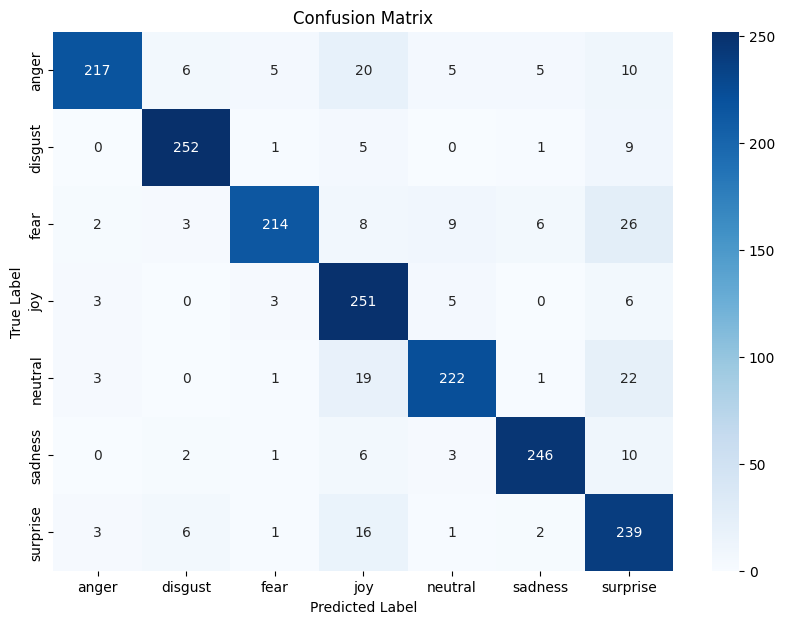

In [13]:
# Plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, label_encoder.classes_)


In [14]:
import numpy as np

def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for audio_batch, video_batch, embeddings_batch, labels_batch in data_loader:
            # Forward pass
            outputs = model(audio_batch, video_batch, embeddings_batch)
            
            # Get predicted probabilities
            probs = F.softmax(outputs, dim=1)
            
            # Store probabilities and true labels
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)


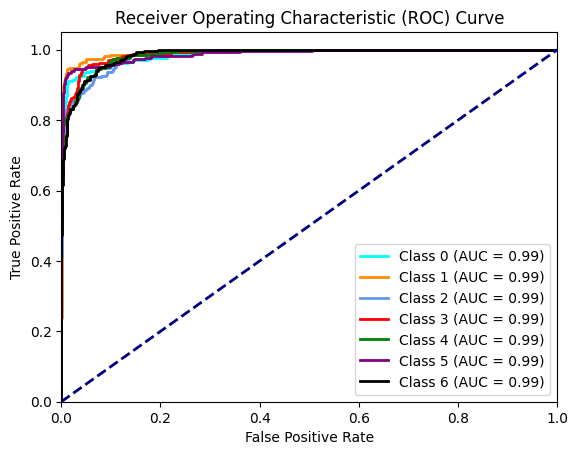

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model
all_preds, all_labels = evaluate_model(model, train_loader)

# Compute ROC curve and AUC for each class
n_classes = 7  # Number of classes
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Binarize the labels for the current class
    y_true = (all_labels == i).astype(int)
    y_score = all_preds[:, i]
    
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'black']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [16]:
import torch

# Save the model
torch.save(model.state_dict(), 'multimodal_model.pth')

# Load the model (when needed)
loaded_model = MultimodalModel()
loaded_model.load_state_dict(torch.load('multimodal_model.pth'))
loaded_model.eval()


MultimodalModel(
  (audio_fc): Linear(in_features=13, out_features=64, bias=True)
  (video_fc): Linear(in_features=36, out_features=64, bias=True)
  (embedding_fc): Linear(in_features=4096, out_features=128, bias=True)
  (combined_fc): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=7, bias=True)
)

In [17]:
from sklearn.preprocessing import LabelEncoder
import joblib


In [18]:
# Save the LabelEncoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']